This is the banchmarking of the network architecture 

In [1]:

import sys
sys.path.append('../../..')

import os
os.environ['PYTHONPATH'] = '../../..'

In [2]:
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine,text

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim

## MedFL Imports 
## Network Manager Imports 
from Medfl.NetManager.node import Node
from Medfl.NetManager.network import Network
from Medfl.NetManager.dataset import DataSet
from Medfl.NetManager.flsetup import FLsetup

# flower imports 
import flwr as fl

## Learning Manager imports 
from Medfl.LearningManager.dynamicModal import DynamicModel
from Medfl.LearningManager.model import Model
from Medfl.LearningManager.strategy import Strategy
from Medfl.LearningManager.server import *
from Medfl.LearningManager.flpipeline import *
from Medfl.LearningManager.plot import AccuracyLossPlotter



# Utils
from Medfl.LearningManager.utils import *


C:\Users\HP User\AppData\Local\Temp\ipykernel_25256\3319853876.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-21 01:41:15,021	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
# DB Creation 
!python ../../../scripts/create_db.py

# clearn DB 
# empty_db()

d:\ESI\3CS\PFE\last_year\Code\MEDfl\scripts\create_db.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
# Create a nest work "Net_1"
Net_1 = Network(name="manual_network_2")
Net_1.create_network()

Net_1.name

'manual_network_2'

In [5]:
# Create a MasterDataSet from Net_1
Net_1.create_master_dataset()

# Check if the Network has a masterDataSet Table ( 1: Table exists ; 0: Table doesn't exist)
Net_1.mtable_exists

D:\ESI\3CS\PFE\last_year\Code\MEDfl/notebooks/data/masterDataSet/Mimic_ouael.csv


1

In [6]:
# auto FLsetup creation
autoFl  = FLsetup(name = "Flsetup_2", description = "The second fl setup",network = Net_1)
autoFl.create()

# List all setups 
FLsetup.list_allsetups()

FLsetupId       name          description       creation_date  NetId  \
0          1  Flsetup_2  The second fl setup 2024-03-21 01:41:36      1   

  column_name  
0        None

# Configuration_1: A Manual network with 50 Nodes 
This network contains 50 nodes (40 Train nodes and 10 test nodes)

In [7]:
# Create 40 train nodes
for i in range(1,6):
    hospital = Node(name="hospital_"+str(i) , train=1)
    Net_1.add_node(hospital)
    hospital.upload_dataset("hospital_"+str(i)+'_dataset' , global_params['base_url']+ '/notebooks/data/nodesData/output_'+str(i)+'.csv')


In [8]:
# Create 10 test nodes
for i in range(6,11):
    hospital = Node(name="hospital_"+str(40+i) , train=0)
    Net_1.add_node(hospital)
    hospital.upload_dataset("hospital_"+str(40+i)+'_dataset' , global_params['base_url']+ '/notebooks/data/nodesData/output_'+str(i)+'.csv')

In [9]:
# List all created nodes on the db 
Node.list_allnodes()

NodeId     NodeName  train  NetId
0       1   hospital_1      1      1
1       2   hospital_2      1      1
2       3   hospital_3      1      1
3       4   hospital_4      1      1
4       5   hospital_5      1      1
5       6  hospital_46      0      1
6       7  hospital_47      0      1
7       8  hospital_48      0      1
8       9  hospital_49      0      1
9      10  hospital_50      0      1

In [10]:
# Create FLDataSet
fl_dataset = autoFl.create_federated_dataset(
    output="deceased", 
    fit_encode=[], 
    to_drop=[ "deceased" ]
    )

In [11]:
fl_dataset.size

17

In [12]:
# Creating a DynamicModel instance
dynamic_model = DynamicModel()

# Creating a specific model dynamically using DynamicModel
specific_model = dynamic_model.create_model(model_type='Logistic Regressor', params_dict={"input_dim": 17, "output_dim": 1})

# Pass the specific_model to the Model class
optimizer = optim.SGD(specific_model.parameters(), lr=0.0001)
criterion = nn.BCELoss()


# Creating a new Model instance using the specific model created by DynamicModel
global_model = Model(specific_model, optimizer, criterion)

# The modal to be passed to the server
global_model.get_parameters()

[array([[-0.19287744, -0.15479593, -0.07340494,  0.17492747,  0.0746356 ,
          0.0290359 , -0.17152557, -0.15779404, -0.12523171,  0.14842144,
          0.20322552,  0.08128414,  0.2372028 , -0.01805884,  0.10851038,
          0.20537335,  0.03058577]], dtype=float32),
 array([0.21642819], dtype=float32)]

In [13]:
# Define the neural network model using PyTorch
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

In [14]:
# Load the pretrained model
model = Model.load_model("../../../notebooks/.ipynb_checkpoints/trainedModels/grid_search_classifier.pth")


# Pass the specific_model to the Model class
optimizer = optim.SGD(model.parameters(), lr=0.0001)
# Define loss function and optimizer
pos_weight = torch.tensor([7 ])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Creating a new Model instance using the specific model created by DynamicModel
global_model = Model(model, optimizer, criterion)

# Get the initial params of the model 
init_params = global_model.get_parameters() ; 

print(model)

Sequential(
  (0): Linear(in_features=17, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


In [15]:
# Create the strategy
fed_avg = Strategy("FedAvg", 
                   fraction_fit = 1.0 ,
                   fraction_evaluate = 1.0,
                   min_fit_clients = 2,
                   min_evaluate_clients = 2,
                   min_available_clients = 2 , 
                   initial_parameters=global_model.get_parameters())

In [16]:
fed_avg.create_strategy() ; 

In [17]:
# Create The server 
server = FlowerServer(global_model, strategy = fed_avg, num_rounds = 10,
                       num_clients  = len(fl_dataset.trainloaders), 
                       fed_dataset = fl_dataset,diff_privacy = True ,
                       # You can change the resources alocated for each client based on your machine 
                       client_resources={'num_cpus': 1.0, 'num_gpus': 0.0}
                       )

In [18]:
# Create the pipeline 
ppl_1 = FLpipeline( name ="the second fl_pipeline",description = "this is our first FL pipeline",
                   server = server)

In [ ]:
# Run the Traning of the model
history = ppl_1.server.run()

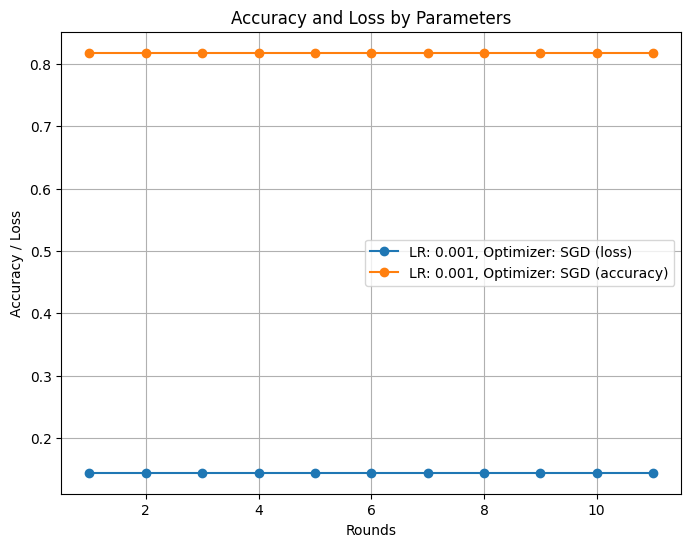

In [ ]:
# Make some plots 
global_accuracy,global_loss = ppl_1.server.accuracies,ppl_1.server.losses
results_dict = {
    ('LR: 0.001, Optimizer: SGD', 'accuracy'): global_accuracy,
    ('LR: 0.001, Optimizer: SGD', 'loss'): global_loss
}
plotter = AccuracyLossPlotter(results_dict)

plotter.plot_accuracy_loss()

In [ ]:
# Test the Modal on the Test nodes and store the results on the DB
ppl_1.auto_test()

[{'node_name': 'hospital_1',
  'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 5, 'TN': 22}, 'Accuracy': 0.815, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.815, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0}"},
 {'node_name': 'hospital_2',
  'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 2, 'TN': 25}, 'Accuracy': 0.926, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.926, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0}"},
 {'node_name': 'hospital_3',
  'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 4, 'TN': 23}, 'Accuracy': 0.852, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.852, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0}"},
 {'node_name': 'hospital_4',
  'classification_report': "{'confusion matrix': {'TP': 2, 'FP': 0, 'FN': 8, 'TN': 17}, '

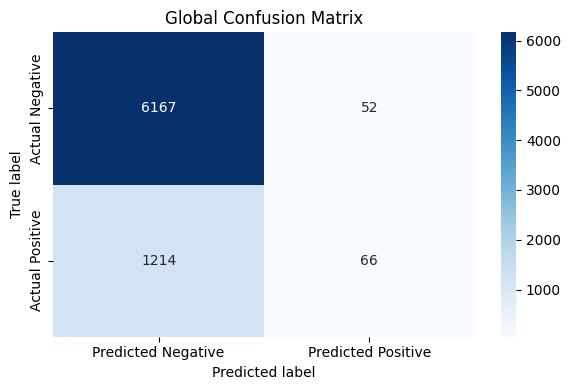

In [ ]:
# Plot the Global confusion Matrix of the pipiline "the first fl_pipeline"
AccuracyLossPlotter.plot_global_confusion_matrix(pipeline_name="the second fl_pipeline")

/home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/Medfl/LearningManager/plot.py:226: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


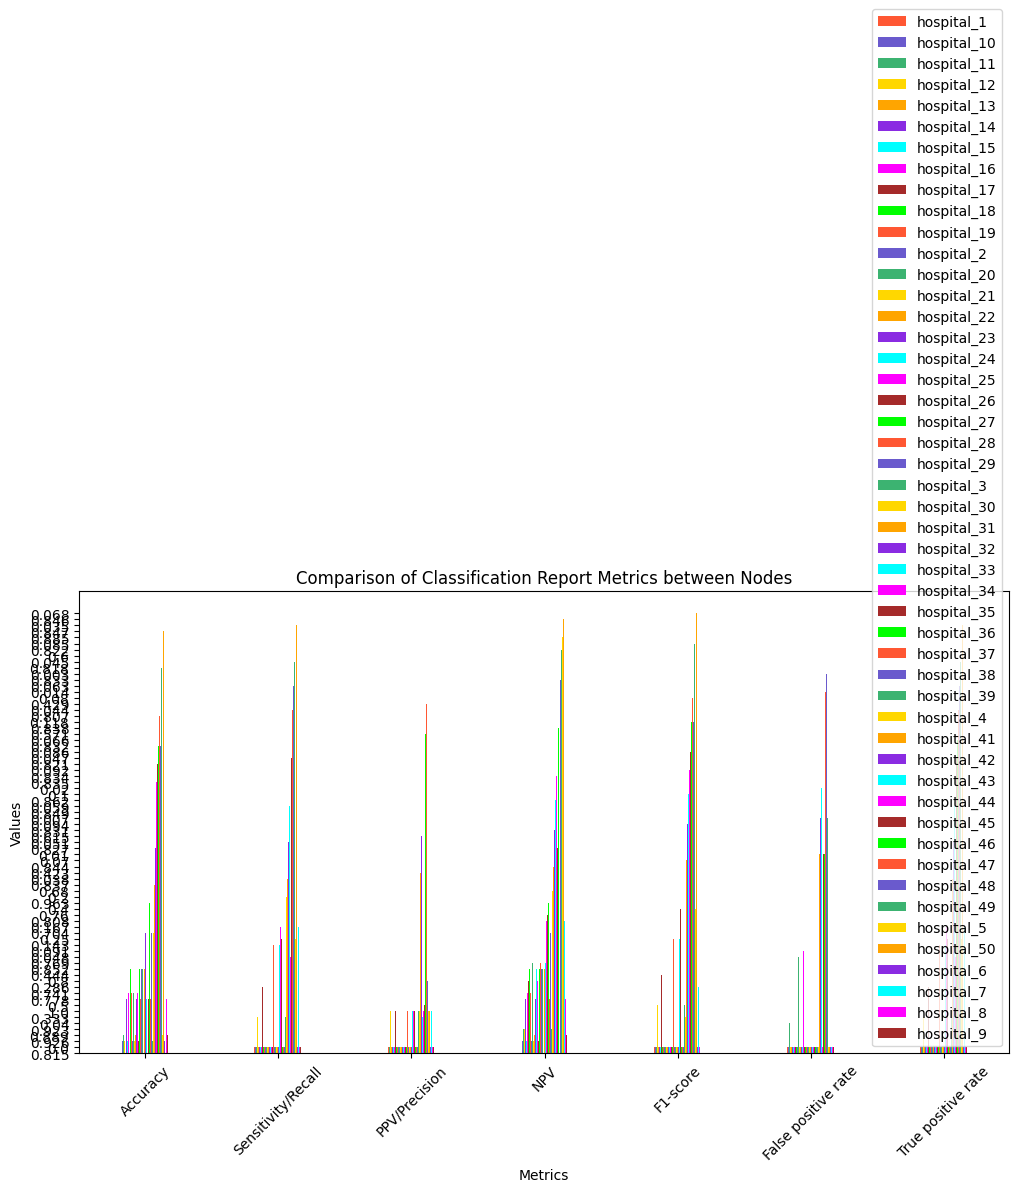

In [ ]:
AccuracyLossPlotter.plot_classification_report(pipeline_name="the first fl_pipeline")